In [9]:
import os
import json
import pickle

import pandas as pd
import numpy as np
import shutil
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(25, 16)}, font_scale=2)
sns.set_style("whitegrid")

import sys
sys.path.insert(1, '../network_analysis/')
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [27]:
def graph_stats_with_gt(df, gt_homographs):
    '''
    Returns an updated `df` that contains the `is_homograph` column as well as its type
    '''
        
    is_homograph_list=[]
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if row['node_type']=='attr':
            is_homograph_list.append(np.nan)
        else:
            if row['node'] in gt_homographs:
                is_homograph_list.append(True)
            else:
                is_homograph_list.append(False)
    
    df['is_homograph']=is_homograph_list
    return df

def get_homograph_type(df, gt_homographs, mode):
    homograph_mode_list=[]

    homographs_traditional=set([str(val) for val in gt_homographs['homographs_traditional']])
    homographs_symbolic_code=set([str(val) for val in gt_homographs['homographs_symbolic_code']])
    homographs_symbolic_numeric=set([str(val) for val in gt_homographs['homographs_symbolic_numeric']])
    homographs_null_equivalent=set([str(val) for val in gt_homographs['homographs_null_equivalent']])

    for idx, row in df.iterrows():
        if mode=='homographs_all':
            if row['is_homograph']:
                if row['node'] in homographs_traditional:
                    homograph_mode_list.append('homographs_traditional')
                elif row['node'] in homographs_symbolic_code:
                    homograph_mode_list.append('homographs_symbolic_code')
                elif row['node'] in homographs_symbolic_numeric:
                    homograph_mode_list.append('homographs_symbolic_numeric')
                elif row['node'] in homographs_null_equivalent:
                    homograph_mode_list.append('homographs_null_equivalent')               
                else:
                    homograph_mode_list.append(np.nan)
            else:
                homograph_mode_list.append(np.nan)
        else:
            if row['is_homograph']:
                homograph_mode_list.append(mode)
            else:
                homograph_mode_list.append(np.nan)
    df['homograph_mode']=homograph_mode_list
    return df

# Analysis over Synthetic Benchmark Large 3

In [29]:
input_dir='../network_analysis/output/synthetic_example_large3/'
graph_dir='../graph_construction/combined_graphs_output/synthetic_benchmark_large3/'
with open('datasets/synthetic_benchmark_large3/selected_homographs.json') as f:
    gt_homographs=json.load(f)

num_homographs=100
modes=['homographs_traditional', 'homographs_symbolic_code', 'homographs_symbolic_numeric', 'homographs_null_equivalent', 'homographs_all']

eval_dfs={}

for mode in modes:
    graph_stats_df=pd.read_pickle(input_dir+mode+'_'+str(num_homographs)+'/graph_stats_df.pickle')
    
    # Get graph and consider only cell nodes with greater than 1 degree
    graph_stats_df = graph_stats_df[graph_stats_df['node_type']=='cell'].sort_values(by='approximate_betweenness_centrality', ascending=False)
    with open(graph_dir+mode+'_'+str(num_homographs)+'/bipartite/bipartite.graph', 'rb') as f:
        G=pickle.load(f)
    nodes_with_degree_greater_than_1 = [n for n in graph_stats_df['node'].values if G.degree[n] > 1]
    graph_stats_df = graph_stats_df.loc[graph_stats_df['node'].isin(nodes_with_degree_greater_than_1)]

    # Add ground truth in the dataframe as well as the type
    cur_gt_homographs=set([str(val) for val in gt_homographs[mode]])
    graph_stats_df = graph_stats_with_gt(df=graph_stats_df, gt_homographs=cur_gt_homographs)
    graph_stats_df = get_homograph_type(df=graph_stats_df, gt_homographs=gt_homographs, mode=mode)
    
    # Perform Evaluation
    if mode=='homographs_all':
        graph_stats_df = utils.calculate_measures(df=graph_stats_df, num_true_homographs=4*num_homographs)
    else:
        graph_stats_df = utils.calculate_measures(df=graph_stats_df, num_true_homographs=4*num_homographs)
    
    eval_dfs[mode]=graph_stats_df

with open('evaluation/synthetic_benchmark_large3/eval_dfs.pickle', 'wb') as f:
    pickle.dump(eval_dfs, f)

100%|██████████| 33733/33733 [00:02<00:00, 15210.62it/s]


## Evaluation

In [30]:
eval_dfs = pd.read_pickle('evaluation/synthetic_benchmark_large3/eval_dfs.pickle')
for mode in eval_dfs:
    eval_dfs[mode].loc[:,'rank'] = list(range(1, eval_dfs[mode].shape[0] + 1))

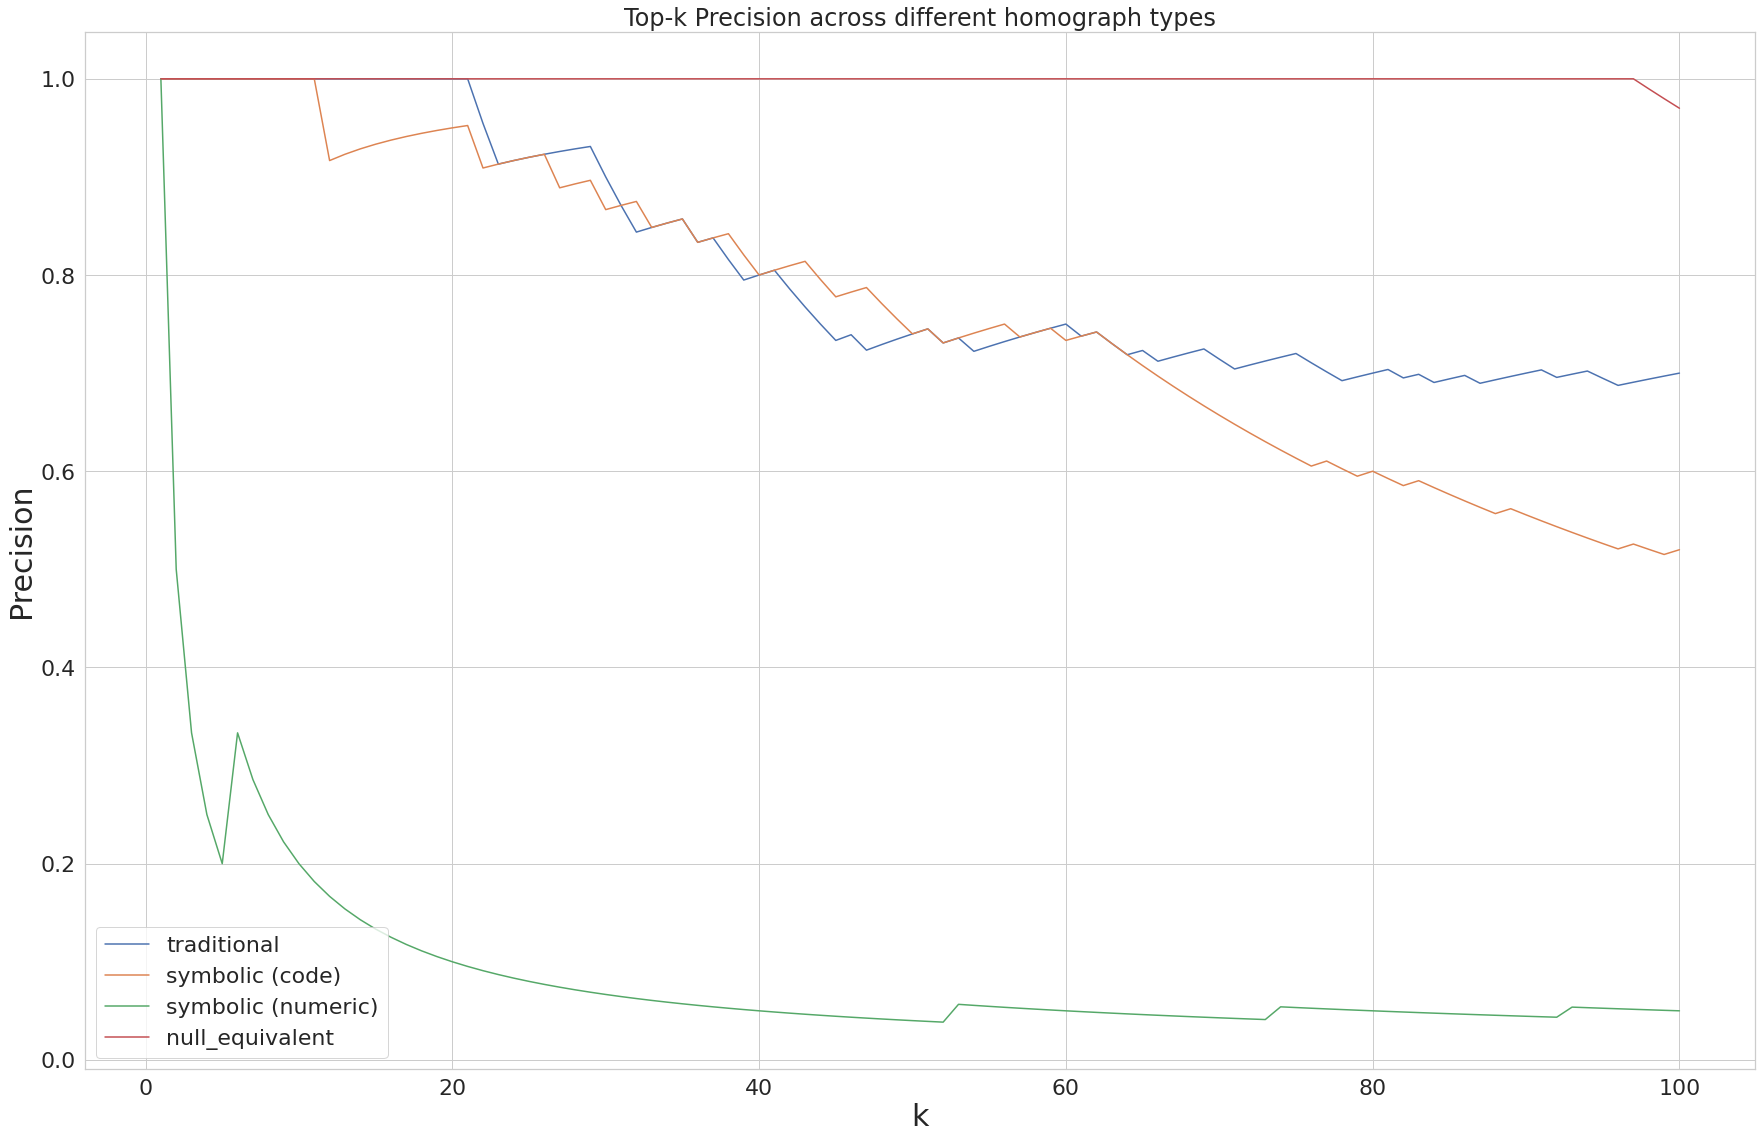

In [40]:
mode_to_label={"homographs_traditional": "traditional", "homographs_symbolic_code": "symbolic (code)", "homographs_symbolic_numeric": "symbolic (numeric)", "homographs_null_equivalent": "null_equivalent"}
k=100
for mode in mode_to_label:
    plt.plot(eval_dfs[mode]['rank'].head(k), eval_dfs[mode]['precision'].head(k), label=mode_to_label[mode])
plt.ylabel('Precision', fontsize=30);plt.xlabel('k', fontsize=30);plt.tight_layout();plt.title('Top-k Precision across different homograph types')
plt.legend(loc='lower left')

In [24]:
eval_dfs['homographs_symbolic_numeric'][eval_dfs['homographs_symbolic_numeric']['is_homograph']==True]

,node,node_type,approximate_betweenness_centrality,is_homograph,homograph_mode,precision,recall,f1_score,rank
